# Sentiment Classification on Nuclear Energy



In light of the need for alternative energy due to climate change,  Nuclear Energy, as one of the main renewable sources, has been a divisive and polarizing topic. 

Predicting the sentiment of a certain tweet, Nuclear Energy companies and lawmakers can identify specific words or phrases around nuclear energy that lend to a negative or positive perception. This allows messaging to be tailored to a specific audience without being oblivious to their opinions. For example:
- Focusing on solutions connected to the negative words can help address concerns. 
- Highlighting the positive words can amplify the support of nuclear energy.

Our dataset contained 3,000 tweets scraped via Twint from Twitter using the search term 'Nuclear Energy'.  All tweets were pulled from 2020. The sentiment of each tweet was trained using Vader and modification of its metrics.  The three sentiments used in this project were: Positive, Negative and Neutral.

In [59]:
#importing all necessary libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import string
from matplotlib import style

#### Data cleaning and processing
- English stopwords were removed. 
- 'Nuclear Energy' , 'nuclearenergy', 'energy' were also removed. 
- Punctuation, links and non-alphabetical characters were also scrubbed from the tweets.
- Each tweet was tokenized and all words were lowercased. 


## EDA 
- Our inital EDA focused on visualizing word frequency for each sentiment 
    - analyzing the most frequent words of each class
- Target distribution is unbalanced 


In [16]:
#reading in 2020 tweets for nuclear energy with labels attached
df = pd.read_csv('tweets_2020_labeled.csv',index_col=0)

In [34]:
X = df['tweet']
y = df['labeled_tweet']

In [17]:
#creating df with just tweet text and sentiment label
tweet_df=df[['tweet','labeled_tweet']]

#function to remove punctuation and non-alphabetical characters
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

#test = clean_text_round1(tweet_df['tweet'][24])
round1 = lambda x: clean_text_round1(x)
tweet_df.tweet = pd.DataFrame(tweet_df.tweet.apply(round1))

def tokenize(text):
     text = [word_tokenize(x) for x in text]
     return text

tweet_df.tweet = tokenize(tweet_df.tweet)

#defining stopwords and removing stopwords from tweet text
stopwords_list = stopwords.words('english')
stopwords_list += ['nuclear','energy','…','nuclearenergy','’','核エネルギーの潜在的な危険性は、いくら強調してもし過ぎるということはない。']
tweet_df.tweet = tweet_df['tweet'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [18]:
tweet_df

,tweet,labeled_tweet
0,"[trump, administration, rescinding, obamaera, ...",neu
1,"[support, ⚛️]",pos
2,"[decrease, renewable, costs, may, serve, accel...",neu
3,"[holtec, highlights, portable, robot, successf...",neu
4,"[ny, saw, little, progress, toward, renewable,...",neu
...,...,...
2995,"[india, participate, following, spacestation, ...",neu
2996,"[go, southerncompany, setting, goal, including...",neu
2997,"[experts, called, us, government, focus, regai...",neu
2998,"[help, country, solve, problems, unemployment,...",pos


In [19]:
#creating a seperate dataframe and unique list for positive words
df_pos=tweet_df[tweet_df['labeled_tweet']=='pos']
pos_list=list(df_pos['tweet'])
total_vocab_pos = set()
for word in pos_list:
    total_vocab_pos.update(word)
len(total_vocab_pos)

#creating a seperate dataframe and unique list for negative words
df_neg=tweet_df[tweet_df['labeled_tweet']=='neg']
neg_list=list(df_neg['tweet'])
total_vocab_neg = set()
for word in neg_list:
    total_vocab_neg.update(word)
len(total_vocab_neg)

#creating a seperate dataframe and unique list for neutral words
df_neu=tweet_df[tweet_df['labeled_tweet']=='neu']
neu_list=list(df_neu['tweet'])
total_vocab_neu = set()
for word in neu_list:
    total_vocab_neu.update(word)
len(total_vocab_neu)

#creating frequency distribution for each list  

flat_pos = [item for sublist in pos_list for item in sublist]
flat_neg = [item for sublist in neg_list for item in sublist]
flat_neu = [item for sublist in neu_list for item in sublist]

pos_freq = FreqDist(flat_pos)
neg_freq = FreqDist(flat_neg)
neu_freq = FreqDist(flat_neu)

In [20]:
# create counts of positive, negative, neutral words and values
positive_bar_counts = [x[1] for x in pos_freq.most_common(20)]
positive_bar_words = [x[0] for x in pos_freq.most_common(20)]

negative_bar_counts = [x[1] for x in neg_freq.most_common(20)]
negative_bar_words = [x[0] for x in neg_freq.most_common(20)]

neutral_bar_counts = [x[1] for x in neu_freq.most_common(20)]
neutral_bar_words = [x[0] for x in neu_freq.most_common(20)]

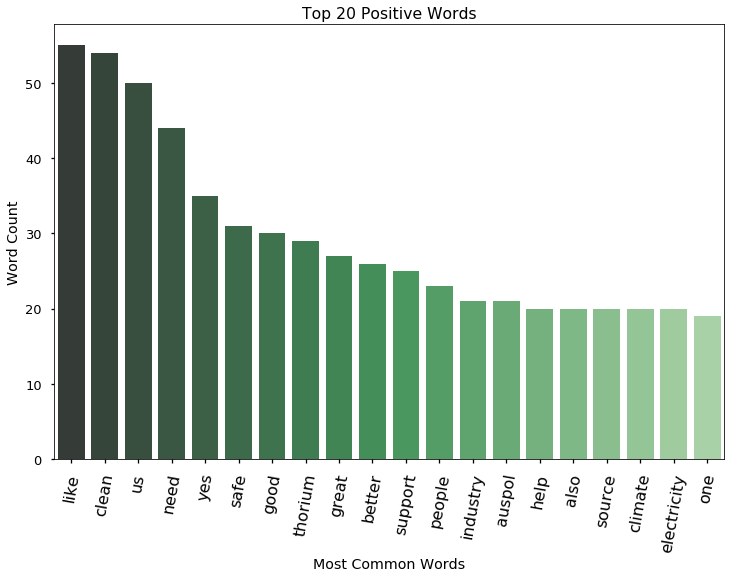

In [21]:
plt.style.use('seaborn-talk')

#bar plot for top 20 most common positive words
word_freq_figure1 = plt.figure(figsize=(12,8))
sns.barplot(positive_bar_words, positive_bar_counts,palette='Greens_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Positive Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

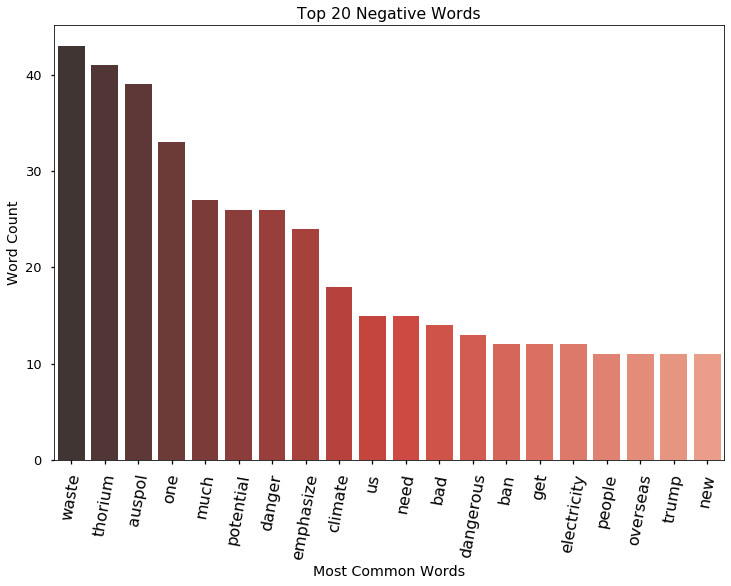

In [22]:
#bar plot for top 20 most common negative words
word_freq_figure1 = plt.figure(figsize=(12,8))
sns.barplot(negative_bar_words, negative_bar_counts,palette='Reds_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Negative Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

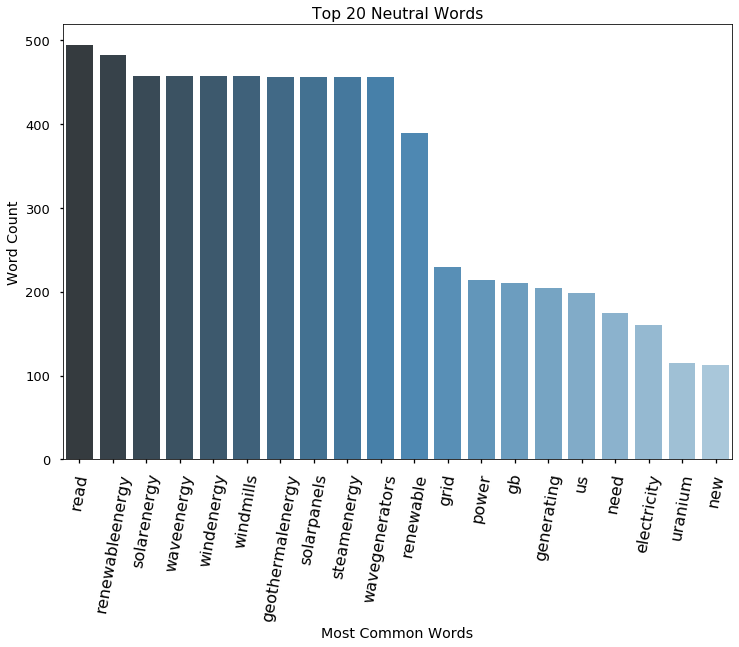

In [23]:
#bar plot for top 20 most common neutral words
word_freq_figure1 = plt.figure(figsize=(12,8))
sns.barplot(neutral_bar_words, neutral_bar_counts,palette='Blues_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Neutral Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

In [24]:
from wordcloud import WordCloud
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))
neutral_dictionary = dict(zip(neutral_bar_words, neutral_bar_counts))

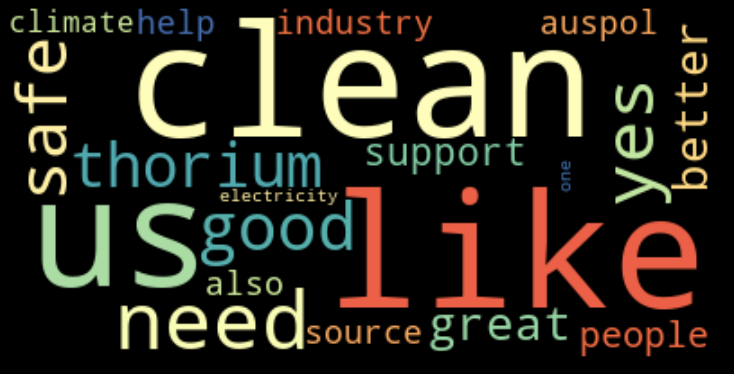

In [28]:
# Create the positive word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(positive_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

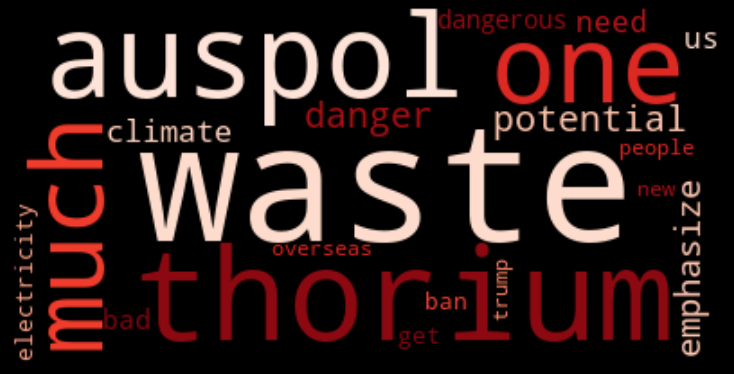

In [29]:
# Create the negative word cloud:

wordcloud = WordCloud(colormap='Reds').generate_from_frequencies(negative_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

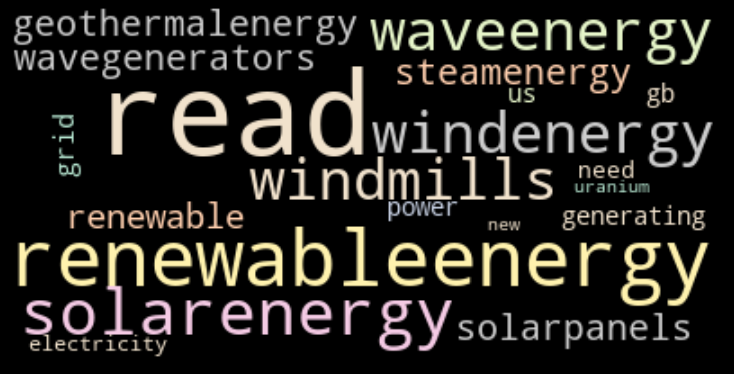

In [30]:
# Create the neutral word cloud:

wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(neutral_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

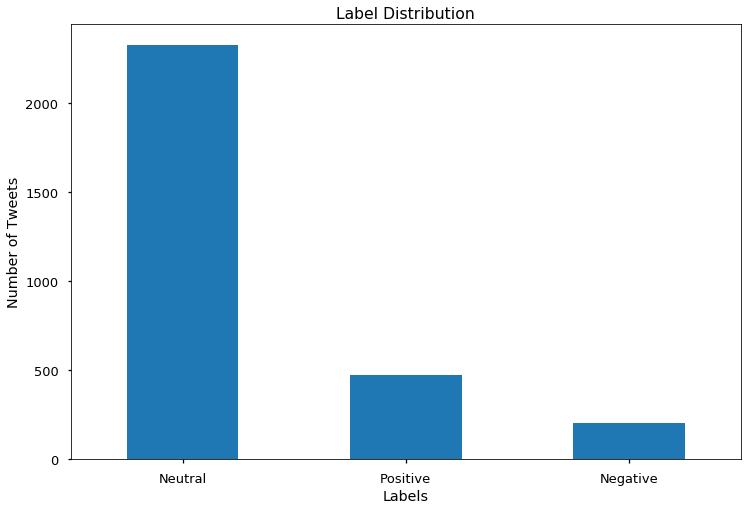

In [35]:
#y = tweet_df['labeled_tweet']
#target distribution 
#there are more positive than negative but majority is neutral
#imbalanced class
plt.style.use('seaborn-talk')
plt.figure() 
fig1 = y.value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Label Distribution')
fig1.set(xticklabels=['Neutral', 'Positive', 'Negative'])
plt.xticks(rotation=0)
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

In [36]:
y.value_counts(normalize=True)

neu    0.775000
pos    0.157667
neg    0.067333
Name: labeled_tweet, dtype: float64

## Modeling

In [37]:
X_fake = pd.DataFrame(X.apply(round1))
X = X_fake['tweet']

In [38]:
#creating test/train split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

#applying tfidf vectorizer to training and testing set 
tfidf = TfidfVectorizer(stop_words = stopwords_list)
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

### Dummy Classifier 
- Baseline dummy classifer that predicts the majority class

In [39]:
from sklearn.dummy import DummyClassifier

dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(tfidf_data_train, y_train)

dc_train_preds = dc_classifier.predict(tfidf_data_train)
dc_test_preds = dc_classifier.predict(tfidf_data_test)
dc_train_score = accuracy_score(y_train, dc_train_preds)
dc_test_score = accuracy_score(y_test, dc_test_preds)

print('Dummy with TF-IDF')
print("Training Accuracy: {:.4}".format(dc_train_score))
print("Testing Accuracy: {:.4}".format(dc_test_score))

Dummy with TF-IDF
Training Accuracy: 0.7742
Testing Accuracy: 0.7773


## Naive Bayes 
- performed only a little better than the dummy classifier 
- doesn't account for class imbalance 

In [40]:
#Naiive Bayes Model

nb_classifier = MultinomialNB()

nb_classifier.fit(tfidf_data_train, y_train)

nb_train_preds = nb_classifier.predict(tfidf_data_train)
nb_test_preds = nb_classifier.predict(tfidf_data_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print('Naiive-Bayes with TF-IDF')
print("Training Accuracy: {:.4}".format(nb_train_score))
print("Testing Accuracy: {:.4}".format(nb_test_score))

Naiive-Bayes with TF-IDF
Training Accuracy: 0.7929
Testing Accuracy: 0.7853


Precision Score :  0.6784534050179211
Recall Score :  0.7853333333333333


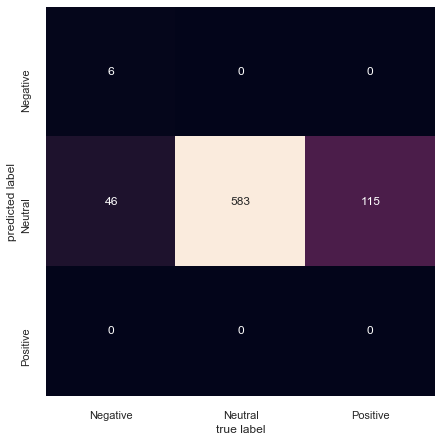

In [67]:
#confusion matrix on test set NB
sns.set()


mat10 = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(mat10.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

print("Precision Score : ",precision_score(y_test, nb_test_preds, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, nb_test_preds, 
                                           average='weighted'))

## Random Forest Classifier
- The RFC performed almost perfect on the training set but not on the test set
- This model might be slightly overfitting


In [46]:
#Random Forest Model

rf_classifier = RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced')

rf_classifier.fit(tfidf_data_train, y_train)

rf_test_preds = rf_classifier.predict(tfidf_data_test)
rf_train_preds = rf_classifier.predict(tfidf_data_train)

rf_acc_score_train = accuracy_score(y_train, rf_train_preds)
rf_acc_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest with TF-IDF')
print("Training Accuracy: {:.4}".format(rf_acc_score_train))
print("Testing Accuracy: {:.4}".format(rf_acc_score))

Random Forest with TF-IDF
Training Accuracy: 0.9991
Testing Accuracy: 0.7827


In [44]:
#feature importance scores.
feat_importanceDF_rfc_2 = pd.DataFrame(rf_classifier.feature_importances_, index=tfidf.vocabulary_)
#feat_importanceDF_rfc_2.sort_values(by=0,ascending=False).head(20)

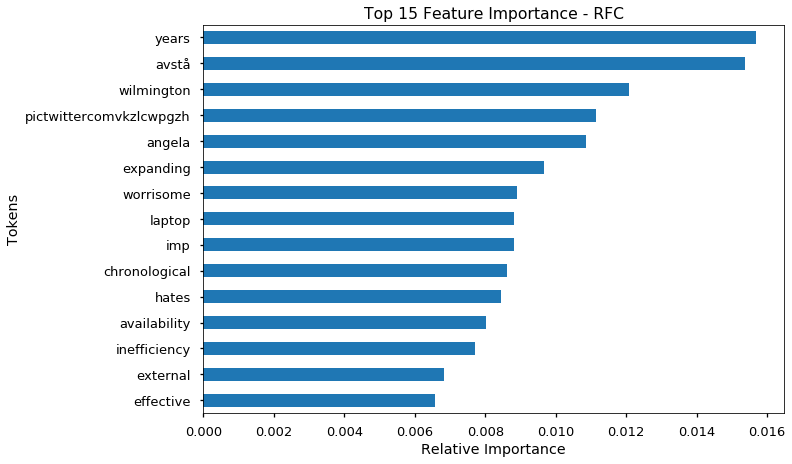

In [43]:
#plot top 5 features for the RFC
feat_importances_2 = pd.Series(rf_classifier.feature_importances_,index=tfidf.vocabulary_)
feat_importances_2.nlargest(15).sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importance - RFC")
plt.xlabel('Relative Importance')
plt.ylabel('Tokens')
plt.show()

Precision Score :  0.7906751452397797
Recall Score :  0.7826666666666666


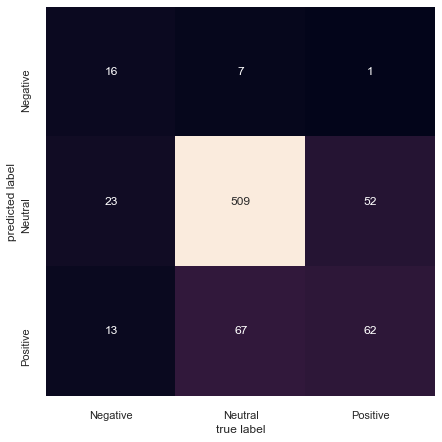

In [66]:
#confusion matrix on test set Random Forest
sns.set()


mat = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

print("Precision Score : ",precision_score(y_test, rf_test_preds, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, rf_test_preds, 
                                           average='weighted'))

## SVM 
- SVM performed better than all other models
- Accuracy, Precision and Recall were all the highest

In [50]:

from sklearn import svm
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(class_weight='balanced')

svm_classifier.fit(tfidf_data_train, y_train)

svm_test_preds = svm_classifier.predict(tfidf_data_test)
svm_train_preds = svm_classifier.predict(tfidf_data_train)

svm_acc_score_train = accuracy_score(y_train, svm_train_preds)
svm_acc_score = accuracy_score(y_test, svm_test_preds)

print('SVM with TF-IDF')
print("Training Accuracy: {:.4}".format(svm_acc_score_train))
print("Testing Accuracy: {:.4}".format(svm_acc_score))

SVM with TF-IDF
Training Accuracy: 0.9924
Testing Accuracy: 0.8213


In [51]:
#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_svm = pd.DataFrame(svm_classifier.coef_)

coef_df=coef_svm.T 

coef_df['tokens']=tfidf.get_feature_names()

coef_df.set_index('tokens',inplace=True)

coef_df.rename(columns={0:'negative',1:'neutral',2:'positive'},inplace=True)

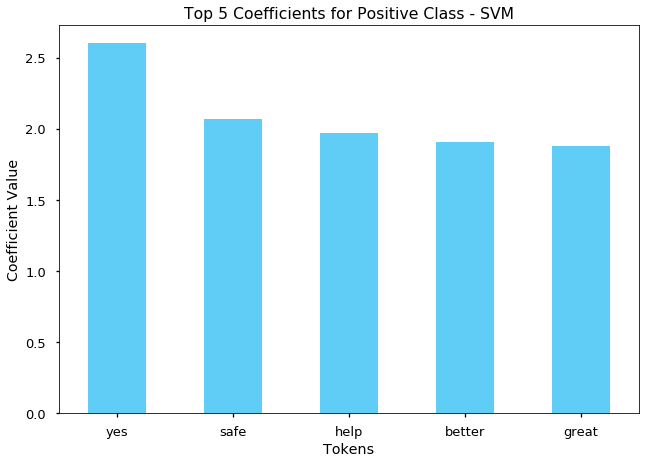

In [53]:
#plotting top 5 feature coefficients for positive
coef_df['positive'].sort_values(ascending=False).head(5).plot(kind='bar',color='#5fcdf5')
plt.title("Top 5 Coefficients for Positive Class - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=0)
plt.show()

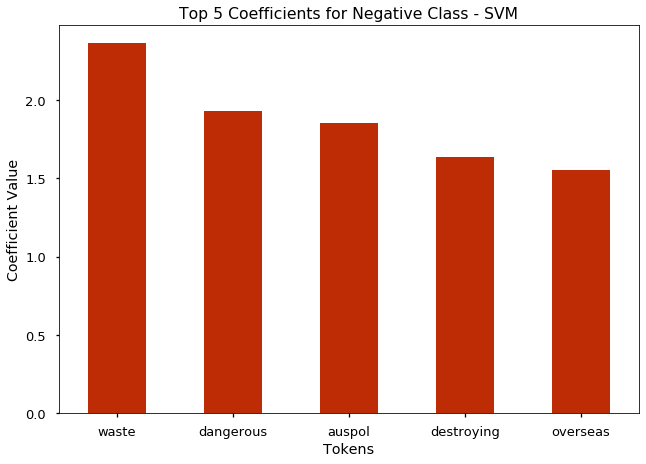

In [55]:
#plotting top 5 feature coefficients for negative class
coef_df['negative'].sort_values(ascending=False).head(5).plot(kind='bar',color='#bd2c04')
plt.title("Top 5 Coefficients for Negative Class - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=0)
plt.show()

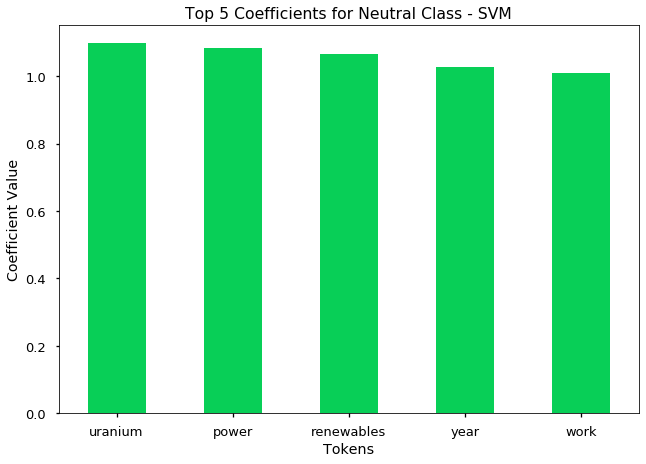

In [56]:
#plotting top 5 feature coefficients for neutral class
coef_df['neutral'].sort_values(ascending=False).head(5).plot(kind='bar',color='#08cf57')
plt.title("Top 5 Coefficients for Neutral Class - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=0)
plt.show()

Precision Score :  0.8085644498299995
Recall Score :  0.8213333333333334


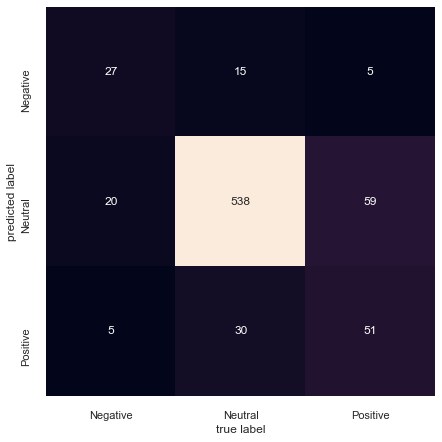

In [65]:
#confusion matrix on test set SVM
sns.set()


mat5 = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(mat5.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

print("Precision Score : ",precision_score(y_test, svm_test_preds, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, svm_test_preds, 
                                           average='weighted'))

## Testing our model with 'Emotions About Nuclear Energy' dataset from CROWDFLOWER
- This dataset contains 190 tweets around nuclear energy and sentiment was labeled via a survey taken by real people
- We wanted to test our model on this dataset and compare how our label predictions measured against public opinion on sentiment around nuclear energy
- This validated the performance of our model in a real world application 

In [68]:
df_crowdflower = pd.read_csv('sentiment_nuclear_power.csv', encoding= 'unicode_escape')

In [69]:
df_crowdflower['sentiment'].replace({'Neutral / author is just sharing information': 'neu', 
                                     'Negative': 'neg', 
                                     'Positive': 'pos',
                                     'Tweet NOT related to nuclear energy': 'neu'}, inplace=True)
X_cf = df_crowdflower['tweet_text']
y_cf = df_crowdflower['sentiment']

y_cf.value_counts(normalize=True)

neu    0.847368
neg    0.100000
pos    0.052632
Name: sentiment, dtype: float64

In [70]:
X_cf_fake = pd.DataFrame(X_cf.apply(round1))
X_cf = X_cf_fake['tweet_text']



tfidf_cf = tfidf.transform(X_cf)

In [71]:
svm_cf = svm_classifier.predict(tfidf_cf)

svm_cf_score = accuracy_score(y_cf, svm_cf)
print('SVM with TF-IDF using crowdflower data')
print("Accuracy: {:.4}".format(svm_cf_score))

SVM with TF-IDF using crowdflower data
Accuracy: 0.7737


Precision Score :  0.7623457094894837
Recall Score :  0.7736842105263158


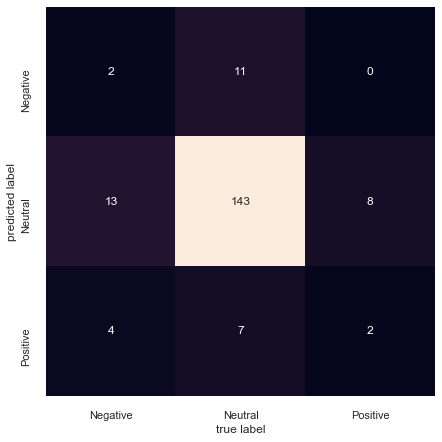

In [75]:
#Confusion Matrix on cf for SVM
sns.set()


mat3_svm = confusion_matrix(y_cf, svm_cf)
sns.heatmap(mat3_svm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label')



print("Precision Score : ",precision_score(y_cf, svm_cf, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_cf, svm_cf, 
                                           average='weighted'))

plt.show()

## Conclusion and Next Steps

The use of social media such as Twitter has been such an important tool for capturing public opinion on any and all topics. This is vital information for companies and policymakers alike. Classifying the sentiment of tweets around nuclear energy shines a light on specific issues and themes regarding this topic. Using SVM we were able to predict sentiment with over 82% accuracy and therefore, extract key words and themes as they relate to each sentiment.  These insights can be really useful for marketing and PR strategies, whether its for an election or pitching a nuclear energy project.

For example, the top negative word from our analysis is "waste", which concludes that the public's concern is greatly around nuclear waste and its consequences rather than the energy source itself. Companies/Lawmakers can then reassure the public that this is also their main concern regarding nuclear and that may help change negative opinions.

One of the top positive words is safe, which companies can then emphasize when promoting nuclear energy.





Next Steps: 
- We would like to consider other features to add to our model along with the tweet text, additional numerical or categorical features around each tweet and see if it makes our model perform better.
    - For example, twitter user follower count, length of a tweet, blue check mark

- We also would like to explore deep nlp and neural net models
    - including word embeddings to see if context is a significant factor for predicting sentiment 